# When Prediction Fails: The Hammer Pitfall

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A4 | Notebook 1 of 3**

This notebook explores why predictive ML fails for causal optimization problems,
using coupon value optimization as the key example.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

---

## 1. Intuition {#intuition}

### When All You Have is a Hammer...

The ML revolution made predictive modeling accessible:

```python
model = MachineLearningModel()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
```

**The Problem**: When everything looks like a prediction problem, causal questions get misframed.

### Two Fundamentally Different Questions

| Question Type | Prediction | Causal Optimization |
|--------------|------------|---------------------|
| Goal | Estimate $E[Y|X]$ | Maximize $Y$ by changing $T$ |
| Example | "What will sales be?" | "How should I set price to maximize profit?" |
| ML helps? | Yes | **Often hurts** |

### The Coupon Problem

**Scenario**: Streaming company wants to optimize coupon values (0, 5, 10, 15 BRL).

**Naive approach**: Build ML model to predict customer value, then personalize coupons by predicted band.

**The twist**: This approach performs *worse* than giving everyone the same coupon!

> **Key insight**: Predicting $Y$ is not the same as estimating $\frac{\partial Y}{\partial T}$.

---

## 2. Formal Treatment {#formal}

### 2.1 The Optimization Problem

We want to find $T^*$ that maximizes expected outcome:

$$T^* = \arg\max_T E[Y|T]$$

For personalization, we want:

$$T^*(x) = \arg\max_T E[Y|T, X=x]$$

### 2.2 Why Prediction Doesn't Help

**Prediction estimates**: $\hat{Y} = f(X, T)$

**Optimization needs**: $\frac{\partial Y}{\partial T} = g(X, T)$

**The problem**: Good prediction of $Y$ doesn't imply good estimation of $\frac{\partial Y}{\partial T}$.

### 2.3 Prediction Partitions Flatten Elasticities

When we partition by predicted $\hat{Y}$:

1. Within each partition, $\hat{Y}$ is approximately constant
2. If $\hat{Y} \approx Y$, then $Y$ varies little within partition
3. With little $Y$ variation, we can't estimate $\frac{\partial Y}{\partial T}$

**Result**: The response curve **flattens** within each prediction band.

### 2.4 Personalization Requirements

Personalization is beneficial **only when**:
1. Multiple treatment options exist ($T \in \{0, 5, 10, 15\}$)
2. No single treatment is universally optimal
3. Different subgroups have different optimal treatments

**Key**: We need to identify subgroups by their *treatment response*, not their *predicted outcome*.

---

## 3. Numeric Demonstration {#numeric}

### Data Generating Process

We simulate a coupon experiment with controlled DGP so we can observe counterfactuals.

In [2]:
def ltv_with_coupons(coupons=None, seed=12):
    """Generate customer lifetime value data with coupon treatment effects.
    
    This DGP has nonlinear treatment effects: coupons interact with age
    and income to affect purchase frequency and transaction values.
    
    Parameters
    ----------
    coupons : array-like, optional
        Coupon values for each customer. If None, generates based on age.
    seed : int
        Random seed for reproducibility.
        
    Returns
    -------
    transactions : pd.DataFrame
        Daily transaction values with customer acquisition cost.
    customer_features : pd.DataFrame
        Customer attributes including assigned coupon values.
    """
    n = 10000
    t = 30  # days
    
    np.random.seed(seed)
    
    # Customer features
    age = 18 + np.random.poisson(10, n)
    income = 500 + np.random.exponential(2000, size=n).astype(int)
    region = np.random.choice(np.random.lognormal(4, size=50), size=n)
    
    # Default coupons: correlated with age (confounding)
    if coupons is None:
        coupons = np.clip(np.random.normal((age - 18), 0.01, size=n) // 5 * 5, 0, 15)
    
    assert len(coupons) == n
    
    np.random.seed(seed)
    
    # Treatment effect on purchase frequency
    freq_mu = 0.5 * coupons * age + age
    freq_mu = (freq_mu - 150) / 30 + 2
    freq = np.random.lognormal(freq_mu.astype(int))
    
    # Churn timing (income-dependent)
    churn = np.random.poisson((income - 500) / 2000 + 22, n)
    
    # Alive indicator per day
    ones = np.ones((n, t))
    alive = (np.cumsum(ones, axis=1) <= churn.reshape(n, 1)).astype(int)
    buy = np.random.binomial(1, ((1 / (freq + 1)).reshape(n, 1) * ones))
    
    # Customer acquisition cost (region-dependent)
    cacq = -1 * abs(np.random.normal(region, 2, size=n).astype(int))
    
    # Treatment effect on transaction values
    transaction_mu = 0.1 + (((income - 500) / 900) * (coupons / 8)) + coupons / 9
    transaction_mu = np.clip(transaction_mu, 0, 5)
    transaction_mu = np.tile(transaction_mu.reshape(-1, 1), t)
    
    np.random.seed(seed)
    transactions = np.random.lognormal(transaction_mu, size=(n, t)).astype(int) * buy * alive
    
    # Build DataFrames
    trans_dict = {"customer_id": range(n), "cacq": cacq}
    for day in range(t):
        trans_dict[f"day_{day}"] = transactions[:, day]
    data = pd.DataFrame(trans_dict)
    
    # Encode regions
    encoded = {value: index for index, value in
               enumerate(np.random.permutation(np.unique(region)))}
    
    customer_features = pd.DataFrame({
        'customer_id': range(n),
        'region': region,
        'income': income,
        'coupons': coupons,
        'age': age
    }).replace({'region': encoded}).astype(int)
    
    return data, customer_features


def process_data(transactions, customer_data):
    """Compute net value per customer including coupon cost."""
    profitable = (transactions[['customer_id']]
                  .assign(net_value=transactions.drop(columns='customer_id').sum(axis=1)))
    
    return (customer_data
            .merge(profitable, on='customer_id')
            .assign(net_value=lambda d: d['net_value'] - d['coupons']))

In [3]:
# Generate baseline data
transactions, customer_features = ltv_with_coupons()
customer_features = process_data(transactions, customer_features)

print(f"Customers: {len(customer_features):,}")
print(f"Features: {customer_features.columns.tolist()}")
customer_features.head()

Customers: 10,000
Features: ['customer_id', 'region', 'income', 'coupons', 'age', 'net_value']


,customer_id,region,income,coupons,age,net_value
0,0,18,1025,5,24,-44
1,1,40,1649,5,26,74
2,2,35,2034,15,33,-23
3,3,29,1859,15,35,-45
4,4,11,1243,5,26,-26


### Coupon Distribution (Non-Random)

In [4]:
# Check coupon distribution
coupon_dist = customer_features.groupby('coupons')['customer_id'].count()
print("Coupon Value Distribution:")
print(coupon_dist)

# Check correlation with age (confounding)
print(f"\nCorrelation with age: {customer_features['coupons'].corr(customer_features['age']):.3f}")
print("(Higher coupons given to older customers)")

Coupon Value Distribution:
coupons
0      458
5     4749
10    4154
15     639
Name: customer_id, dtype: int64

Correlation with age: 0.897
(Higher coupons given to older customers)


### Simple Policy: Give Everyone 5 BRL

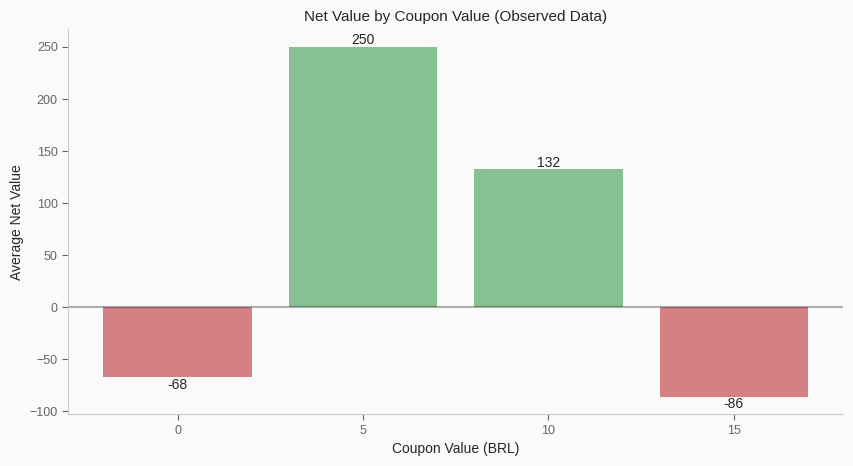

Best observed coupon value: 5 BRL


In [5]:
# Net value by coupon value in observed data
fig, ax = plt.subplots(figsize=(10, 5))

coupon_means = customer_features.groupby('coupons')['net_value'].mean()
colors = [COLORS['green'] if v > 0 else COLORS['red'] for v in coupon_means.values]
bars = ax.bar(coupon_means.index.astype(str), coupon_means.values, color=colors, alpha=0.7)

ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Coupon Value (BRL)')
ax.set_ylabel('Average Net Value')
ax.set_title('Net Value by Coupon Value (Observed Data)')

# Annotate values
for bar, val in zip(bars, coupon_means.values):
    ax.annotate(f'{val:.0f}', (bar.get_x() + bar.get_width()/2, val),
                ha='center', va='bottom' if val > 0 else 'top')

apply_tufte_style(ax)
plt.show()

print(f"Best observed coupon value: {coupon_means.idxmax()} BRL")

In [6]:
# Evaluate simple policy: give everyone 5 BRL coupons
simple_policy = 5 * np.ones(len(customer_features))

trans_simple, feat_simple = ltv_with_coupons(simple_policy)
feat_simple = process_data(trans_simple, feat_simple)

simple_policy_gain = feat_simple['net_value'].mean()

print(f"Simple Policy (5 BRL for all):")
print(f"  Average net value: {simple_policy_gain:.2f} BRL/customer")
print(f"  Total value: {simple_policy_gain * len(feat_simple):,.0f} BRL")

Simple Policy (5 BRL for all):
  Average net value: 252.93 BRL/customer
  Total value: 2,529,268 BRL


### Model-Based Policy: Personalization Attempt

In [7]:
def model_bands(train_set, features, target, model_params, n_bands, seed=1):
    """Train predictive model and create band assignment function.
    
    Returns a function that predicts net_value and assigns to bands.
    """
    np.random.seed(seed)
    
    # Train ML model
    reg = GradientBoostingRegressor(**model_params)
    reg.fit(train_set[features], train_set[target])
    
    # Fit bands (quantiles of predictions)
    bands = pd.qcut(reg.predict(train_set[features]), q=n_bands, retbins=True)[1]
    
    def predict(test_set):
        predictions = reg.predict(test_set[features])
        pred_bands = np.digitize(predictions, bands, right=False)
        return test_set.assign(
            predictions=predictions,
            pred_bands=np.clip(pred_bands, 1, n_bands)
        )
    
    return predict


# Train predictive model
train, test = train_test_split(customer_features, test_size=0.3, random_state=1)

model_params = {
    'n_estimators': 150,
    'max_depth': 4,
    'min_samples_split': 10,
    'learning_rate': 0.01,
    'loss': 'squared_error'
}

features = ['region', 'income', 'age']
target = 'net_value'

model = model_bands(train, features, target, model_params, n_bands=10)

In [8]:
# Evaluate predictive performance
train_preds = model(train)
test_preds = model(test)

train_r2 = r2_score(train['net_value'], train_preds['predictions'])
test_r2 = r2_score(test['net_value'], test_preds['predictions'])

print(f"Predictive Performance:")
print(f"  Train R²: {train_r2:.3f}")
print(f"  Test R²:  {test_r2:.3f}")
print(f"\nThe model is reasonably good at predicting net_value.")

Predictive Performance:
  Train R²: 0.538
  Test R²:  0.505

The model is reasonably good at predicting net_value.


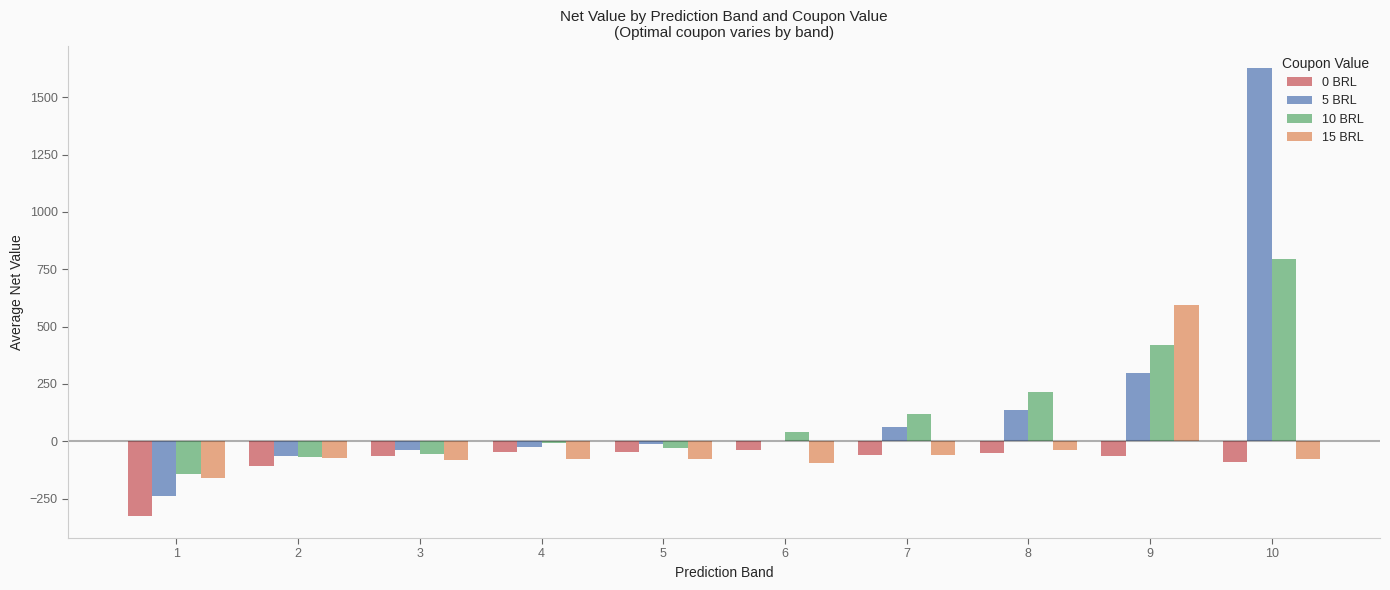

In [9]:
# Visualize net_value by band and coupon value
all_with_bands = model(customer_features)

fig, ax = plt.subplots(figsize=(14, 6))

# Compute means by band and coupon
band_coupon_means = all_with_bands.groupby(['pred_bands', 'coupons'])['net_value'].mean().unstack()

x = np.arange(len(band_coupon_means))
width = 0.2

coupon_colors = {0: COLORS['red'], 5: COLORS['blue'], 10: COLORS['green'], 15: COLORS['orange']}

for i, coupon in enumerate([0, 5, 10, 15]):
    if coupon in band_coupon_means.columns:
        ax.bar(x + i*width, band_coupon_means[coupon], width, 
               label=f'{coupon} BRL', color=coupon_colors[coupon], alpha=0.7)

ax.set_xlabel('Prediction Band')
ax.set_ylabel('Average Net Value')
ax.set_title('Net Value by Prediction Band and Coupon Value\n(Optimal coupon varies by band)')
ax.set_xticks(x + 1.5*width)
ax.set_xticklabels(band_coupon_means.index)
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.legend(title='Coupon Value')
apply_tufte_style(ax)
plt.tight_layout()
plt.show()

In [10]:
# Build personalized policy based on model bands
pred_bands = (model(customer_features)
              .groupby(['pred_bands', 'coupons'])[['net_value']].mean()
              .reset_index())

# Find best coupon per band (rank by net_value)
pred_bands['max_net'] = (pred_bands.groupby('pred_bands')[['net_value']]
                         .rank(ascending=False))

best_coupons_per_band = pred_bands.query('max_net==1')[['pred_bands', 'coupons']]

print("Optimal Coupon by Prediction Band:")
print(best_coupons_per_band.to_string(index=False))

Optimal Coupon by Prediction Band:
 pred_bands  coupons
          1       10
          2        5
          3        5
          4       10
          5        5
          6       10
          7       10
          8       10
          9       15
         10        5


In [11]:
# Apply personalized policy
coupons_per_id = (model(customer_features)
                  .drop(columns=['coupons'])
                  .merge(best_coupons_per_band, on='pred_bands')
                  [['customer_id', 'coupons']]
                  .sort_values('customer_id'))

# Evaluate personalized policy
trans_model, feat_model = ltv_with_coupons(
    coupons_per_id['coupons'].values
)
feat_model = process_data(trans_model, feat_model)

model_policy_gain = feat_model['net_value'].mean()

print(f"\nModel-Based Personalized Policy:")
print(f"  Average net value: {model_policy_gain:.2f} BRL/customer")
print(f"  Total value: {model_policy_gain * len(feat_model):,.0f} BRL")


Model-Based Personalized Policy:
  Average net value: 229.93 BRL/customer
  Total value: 2,299,341 BRL


### The Shocking Result

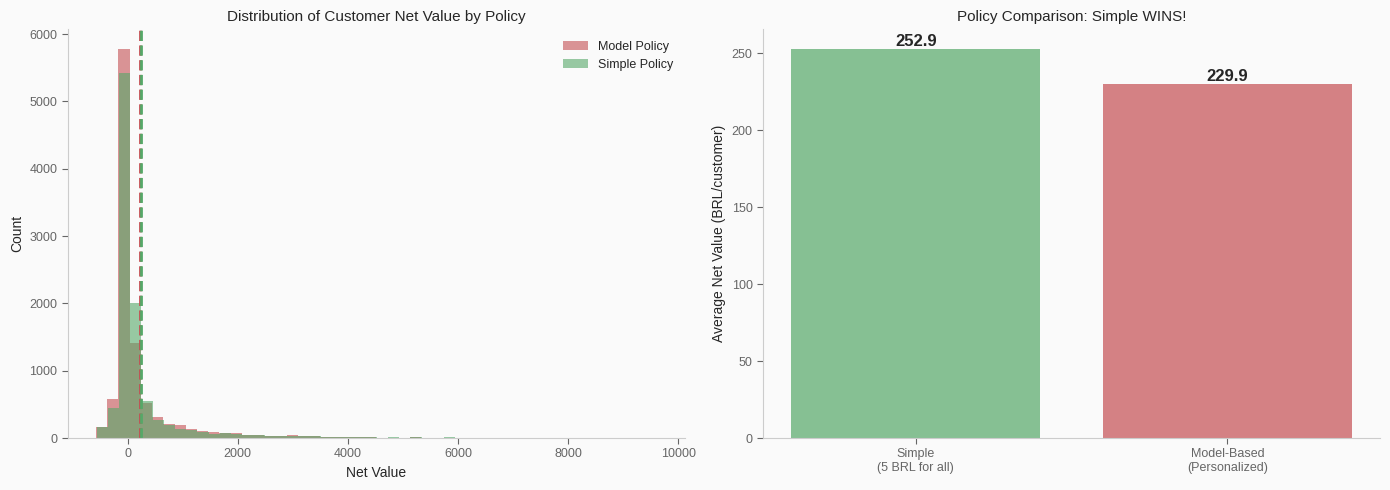


RESULT: Model-based policy is WORSE by 22.99 BRL/customer!


In [12]:
# Compare policies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution comparison
ax = axes[0]
ax.hist(feat_model['net_value'], bins=50, alpha=0.6, label='Model Policy', color=COLORS['red'])
ax.hist(feat_simple['net_value'], bins=50, alpha=0.6, label='Simple Policy', color=COLORS['green'])
ax.axvline(model_policy_gain, color=COLORS['red'], linestyle='--', linewidth=2)
ax.axvline(simple_policy_gain, color=COLORS['green'], linestyle='--', linewidth=2)
ax.set_xlabel('Net Value')
ax.set_ylabel('Count')
ax.set_title('Distribution of Customer Net Value by Policy')
ax.legend()
apply_tufte_style(ax)

# Bar comparison
ax = axes[1]
policies = ['Simple\n(5 BRL for all)', 'Model-Based\n(Personalized)']
gains = [simple_policy_gain, model_policy_gain]
colors = [COLORS['green'], COLORS['red']]
bars = ax.bar(policies, gains, color=colors, alpha=0.7)

for bar, gain in zip(bars, gains):
    ax.annotate(f'{gain:.1f}', (bar.get_x() + bar.get_width()/2, gain),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Average Net Value (BRL/customer)')
ax.set_title('Policy Comparison: Simple WINS!')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print(f"RESULT: Model-based policy is WORSE by {simple_policy_gain - model_policy_gain:.2f} BRL/customer!")
print(f"{'='*50}")

```
★ Insight ─────────────────────────────────────────────────────
The ML model has good predictive power (R² ≈ 0.50), yet the
personalized policy UNDERPERFORMS a trivial "same for everyone" policy.

This is not a bug—it's a fundamental mismatch:
- ML predicts Y (outcome level)
- Optimization needs ∂Y/∂T (treatment effect)

Good prediction ≠ Good optimization guidance.
──────────────────────────────────────────────────────────────
```

---

## 4. Implementation {#implementation}

### Why This Happens: The Core Mechanism

In [13]:
# Demonstrate the flattening effect
# Within each band, compute the "elasticity" of net_value to coupons

def compute_band_elasticities(df, band_col='pred_bands'):
    """Compute approximate treatment effect within each band."""
    results = []
    
    for band in sorted(df[band_col].unique()):
        band_data = df[df[band_col] == band]
        
        # Simple elasticity: change in net_value per unit coupon
        if len(band_data['coupons'].unique()) > 1:
            # Regression of net_value on coupons within band
            if band_data['coupons'].std() > 0:
                slope = np.cov(band_data['coupons'], band_data['net_value'])[0,1] / np.var(band_data['coupons'])
                y_variance = band_data['net_value'].std()
            else:
                slope = 0
                y_variance = 0
        else:
            slope = 0
            y_variance = 0
            
        results.append({
            'band': band,
            'elasticity': slope,
            'y_variance': y_variance,
            'n': len(band_data)
        })
    
    return pd.DataFrame(results)


# Compare elasticities: overall vs within bands
overall_elasticity = (np.cov(customer_features['coupons'], customer_features['net_value'])[0,1] / 
                      np.var(customer_features['coupons']))

band_elasticities = compute_band_elasticities(all_with_bands)

print(f"Overall elasticity (∂Y/∂T): {overall_elasticity:.3f}")
print(f"\nWithin-band elasticities:")
print(band_elasticities[['band', 'elasticity', 'y_variance']].to_string(index=False))
print(f"\nAverage within-band elasticity: {band_elasticities['elasticity'].mean():.3f}")
print(f"\nThe elasticities are FLATTENED within bands!")

Overall elasticity (∂Y/∂T): -14.957

Within-band elasticities:
 band  elasticity  y_variance
    1      9.7938    172.7635
    2      0.3369     95.4635
    3     -3.1618     70.5430
    4      1.2074     55.4532
    5     -3.5153     78.7873
    6      3.8241    157.4792
    7     -2.2949    202.5230
    8     14.3657    389.1939
    9     30.9012    550.2497
   10   -111.0613   1359.6272

Average within-band elasticity: -5.960

The elasticities are FLATTENED within bands!


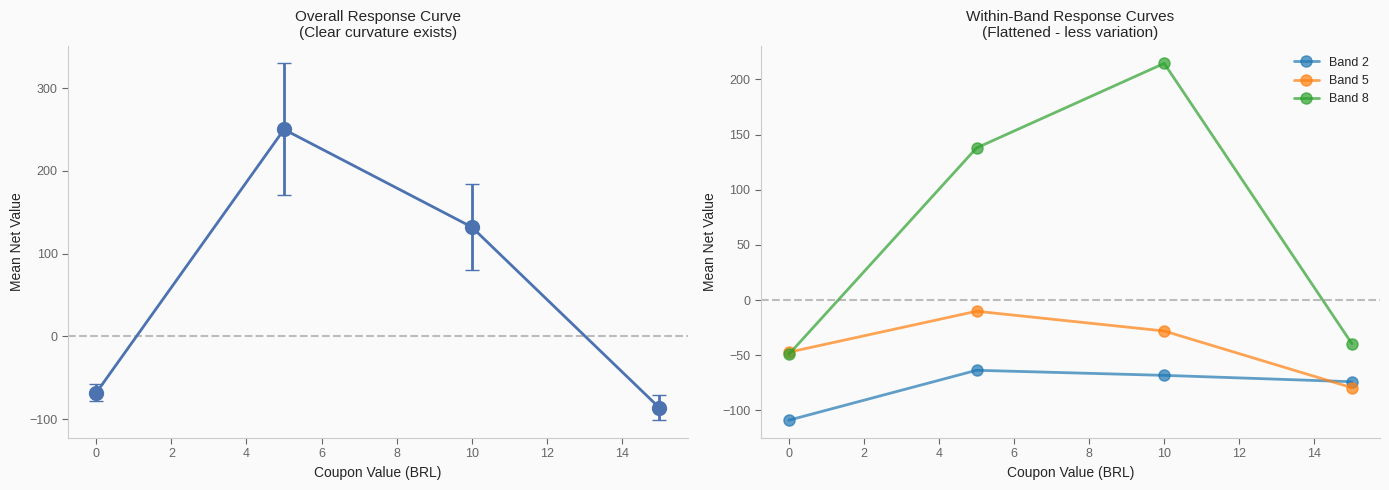

In [14]:
# Visualize the flattening
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall response curve
ax = axes[0]
coupon_response = customer_features.groupby('coupons')['net_value'].agg(['mean', 'std'])
ax.errorbar(coupon_response.index, coupon_response['mean'], 
            yerr=coupon_response['std']/10, fmt='o-', color=COLORS['blue'],
            capsize=5, markersize=10, linewidth=2)
ax.set_xlabel('Coupon Value (BRL)')
ax.set_ylabel('Mean Net Value')
ax.set_title('Overall Response Curve\n(Clear curvature exists)')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
apply_tufte_style(ax)

# Within-band response curves (sample bands)
ax = axes[1]
sample_bands = [2, 5, 8]
for band in sample_bands:
    band_data = all_with_bands[all_with_bands['pred_bands'] == band]
    band_response = band_data.groupby('coupons')['net_value'].mean()
    ax.plot(band_response.index, band_response.values, 'o-', 
            label=f'Band {band}', markersize=8, linewidth=2, alpha=0.7)

ax.set_xlabel('Coupon Value (BRL)')
ax.set_ylabel('Mean Net Value')
ax.set_title('Within-Band Response Curves\n(Flattened - less variation)')
ax.legend()
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

### The Key Equation

**What we want**: Estimate $\frac{\partial Y}{\partial T}$ to find optimal $T$

**What prediction gives us**: Partitions where $Y$ is constant

**The consequence**: When $Y$ doesn't vary, $\frac{\partial Y}{\partial T} \approx 0$

$$\text{Good } \hat{Y} \Rightarrow \text{Low Var}(Y|\text{band}) \Rightarrow \text{Flat } \frac{\partial Y}{\partial T}$$

In [15]:
# Summary table
summary = pd.DataFrame({
    'Approach': ['Simple Policy', 'Model-Based Policy'],
    'Description': ['5 BRL for everyone', 'Personalize by predicted band'],
    'Net Value/Customer': [simple_policy_gain, model_policy_gain],
    'Relative Performance': ['Baseline', f'{(model_policy_gain/simple_policy_gain - 1)*100:.1f}%']
})

print("Policy Comparison Summary:")
print(summary.to_string(index=False))

Policy Comparison Summary:
          Approach                   Description  Net Value/Customer Relative Performance
     Simple Policy            5 BRL for everyone            252.9268             Baseline
Model-Based Policy Personalize by predicted band            229.9341                -9.1%


---

## 5. Interview Appendix {#interview}

### Q1: Why can't ML prediction be used to optimize business decisions?

<details>
<summary>Solution</summary>

**Key distinction**:

| Question | Prediction | Optimization |
|----------|------------|-------------|
| Goal | $E[Y|X]$ | $\arg\max_T E[Y|T]$ |
| Requires | Correlation | Causal effect |
| ML optimizes | Forecast accuracy | Wrong objective |

**Why prediction fails**:
1. Good prediction → partitions where Y is constant
2. Constant Y → no variance to estimate treatment effects
3. No treatment effect → can't identify optimal treatment

**Correct approach**: Estimate treatment effects $\frac{\partial Y}{\partial T}$ directly using causal inference methods (A/B tests, instrumental variables, difference-in-differences).

</details>

### Q2: A data scientist proposes predicting customer LTV and giving larger discounts to predicted high-value customers. What's wrong with this approach?

<details>
<summary>Solution</summary>

**The flaw**: Predicted high-value customers are high-value *regardless* of discounts.

**What we want**: Identify customers whose value *increases most* with discounts (high elasticity).

**The disconnect**:
- High predicted LTV ≠ High response to treatment
- May be giving discounts to customers who would buy anyway
- Missing customers with low baseline but high treatment sensitivity

**Better approach**: Estimate CATE (Conditional Average Treatment Effect):
$$\tau(x) = E[Y_1 - Y_0 | X = x]$$

Target customers with high $\tau(x)$, not high $\hat{Y}(x)$.

</details>

### Q3: When might a predictive model actually help with a causal optimization problem?

<details>
<summary>Solution</summary>

Prediction can help when:

1. **Treatment is random** (no confounding)
   - Conditioning on prediction doesn't block treatment path
   - Can still estimate within-partition treatment effects

2. **Monotonic relationship** between $Y$ and $\frac{\partial Y}{\partial T}$
   - Example: Customers with low baseline satisfaction have high sensitivity to service improvements
   - Partitioning by predicted Y also partitions by elasticity

3. **Variance reduction** (not personalization)
   - Good predictions reduce outcome variance
   - More precise ATE estimates (not CATE)

**Key caveat**: Even when helpful, prediction is not optimal. Purpose-built causal models (T-learner, X-learner, R-learner) will outperform.

</details>

### Q4: Explain the "flattening" phenomenon in one sentence.

<details>
<summary>Solution</summary>

"When you group data by predicted outcome, within-group outcome variation shrinks, and with it your ability to estimate how treatments affect outcomes."

Mathematical form:
$$\hat{Y} \approx Y \Rightarrow \text{Var}(Y|\text{partition}) \to 0 \Rightarrow \frac{\partial Y}{\partial T} \approx 0$$

</details>

### Q5: How would you properly solve the coupon optimization problem?

<details>
<summary>Solution</summary>

**Step 1**: Frame as causal question
- Treatment: Coupon value $T \in \{0, 5, 10, 15\}$
- Outcome: Net customer value $Y$
- Goal: Estimate $E[Y|do(T=t)]$ for each $t$

**Step 2**: Choose identification strategy
- Randomized experiment (gold standard)
- Or: Use existing data with causal methods (if confounders observed)

**Step 3**: Estimate heterogeneous effects
- Use CATE estimators: T-learner, X-learner, Causal Forest
- Target: $\tau(x) = E[Y(t_1) - Y(t_0) | X=x]$

**Step 4**: Personalize based on estimated effects
- Assign treatment with highest expected value
- $T^*(x) = \arg\max_t \hat{E}[Y|do(T=t), X=x]$

</details>

---

## 6. References {#references}

[^1]: Athey, S., & Imbens, G. (2016). Recursive partitioning for heterogeneous causal effects. 
      *PNAS*, 113(27), 7353-7360.

[^2]: Chernozhukov, V., et al. (2018). Double/Debiased Machine Learning for Treatment and 
      Structural Parameters. *Econometrics Journal*, 21, C1-C68.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix: When Prediction Fails.

[^4]: Mullainathan, S., & Spiess, J. (2017). Machine Learning: An Applied Econometric Approach.
      *Journal of Economic Perspectives*, 31(2), 87-106.